# <center>  Notebook S03. Size Distribution Arithmetic </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook introduces the concept of size distribution arithmetic. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, DataFrames, DifferentialMobilityAnalyzers
using LinearAlgebra, SpecialFunctions, Printf
plotlyjs();   

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Representation of the (lognormal) size distribution
The multi-modal lognormal size distribution is given by (e.g. Seinfeld and Pandis, 2006)
<center> $\frac{dN}{d\ln D_p} = \sum_{i=1}^n \frac{N_{t,i}}{\sqrt{2\pi}\ln\sigma_{g,i}} \exp \left(- \frac{\left[\ln D_p-\ln D_{pg,i}\right]^2}{2\ln \sigma_{g,i}^2}\right) $  </center>
where $\frac{dN}{d\ln D_p}$ is the spectral number density, $N_{t,i}$ is the total number concentration, $\sigma_{g,i}$ is the geometric standard deviation, and $D_{pg,i}$ is the geometric mean diameter of the $i^{th}$ mode, and $n$ is the number of modes. <br> 

The function ```lognormal(A; D1 = D1, D2 = D2, bins = n)``` is defined in aerosolsizedistribution.jl and generates a discrete lognormal size distribtution between diameters D1 and D2 with n bins. A is an array of modes allowing to specify an arbitrary number of modes for the distribution, e.g. ```A = [[Nt1, Dpg1,σ1], [Nt2, Dpg2,σ2], ...]```. The function returns a structure of type SizeDistribution, that represents the discrete distribution as shown in the Table below.

In [2]:
r = x->Int.(round.(x, digits = 0))  # Function to round and convert to Int
𝕟 = lognormal([[200, 80, 1.2]]; d1 = 30.0, d2 = 300.0, bins = 10); 
DataFrame(Dlow = r(𝕟.De[1:end-1]),Dup = r(𝕟.De[2:end]),ΔlnD = round.(𝕟.ΔlnD,digits=2),
    Dp = r(𝕟.Dp), S = r(𝕟.S),N = r(𝕟.N))

,Dlow,Dup,ΔlnD,Dp,S,N
,Int64,Int64,Float64,Int64,Int64,Int64
1,30,38,0.23,34,0,0
2,38,48,0.23,42,1,0
3,48,60,0.23,53,37,9
4,60,75,0.23,67,276,64
5,75,95,0.23,85,418,96
6,95,119,0.23,106,128,30
7,119,150,0.23,134,8,2
8,150,189,0.23,169,0,0
9,189,238,0.23,212,0,0


<b> Table 1. </b> Example representation of a lognormal aerosol size distribution on a 10-bin geometrically stepped grid ranging from 30 to 300 nm with geometric standard deviation 1.2 and total number concentration 200 cm⁻³ . Column 1 gives the bin number, Dlow is the lower bin diameter, Dup is the upper bin diameter, ΔlnD = ln(Dup) - ln(Dlow), Dp = $\sqrt{Dup \cdot Dlow}$ is the geometric midpoint diameter of the bin, S $\equiv \frac{dN}{d\ln Dp}$ is the number spectral density [cm⁻³] and N = $\frac{dN}{d\ln Dp} \cdot d\ln Dp$ is the number concentration in each bin [cm⁻³]. The total number concentration is recovered by summing over all bins, i.e. Nt = $\sum_{i=1}^{10} N$. For a geometrically stepped grid, the ΔlnD is identical in each bin. Numbers are rounded for clarity. 

Any size distribution can be represented by the size distribution structure. To indicate size distribution structures this code used double stroke fonts to indicate size distributions, e.g. 𝕟, 𝕣, or 𝕤. The size distribution structure contains the following fieldnames.

In [3]:
fieldnames(SizeDistribution)

(:A, :De, :Dp, :ΔlnD, :S, :N, :form)

The field form contains a symbol to label which function generated the size distribution. For example:

In [4]:
𝕟.form

:lognormal

The size distribution is graphed as follows

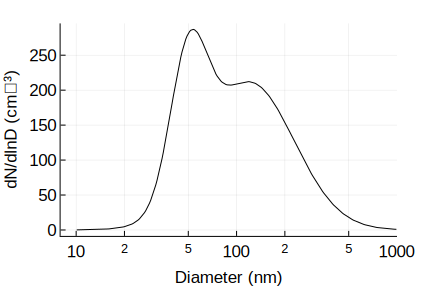

In [5]:
# Generate a lognormal size distribution that serves as input. 
#   - Nt is in [# m-3] for calculations with k12
#   - Dg is in nm in accordance with the grid uings
#   - σ is the geometeric standard deviation (σ > 1)
# Multiple modes can be defined by concatenation. A single mode is permissible A = [[Nt1,Dg1,σ1]]
𝕟 = lognormal([[130, 50, 1.3], [340, 120, 1.9]]; d1 = 10.0, d2 = 1000.0, bins = 256); 

figure("Nimbus Sans L", 2, 3, 2, 8)
p = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, xticks = [10, 100, 1000], legend = :none, right_margin = 35px,
    ylabel = "dN/dlnD (cm⁻³)", xlim = (8,1000), color =  :black, xlabel = "Diameter (nm)", fmt = :svg)

<b> Figure 1. </b> Two mode lognormal size distribution for $N_{t,1} = 130\; cm^{-3}$, $D_{pg,1} = 50\; nm$,  $\sigma_{g,1} = 1.3$, $N_{t,2} = 340\; cm^{-3}$, $D_{pg,2} = 120\; nm$ amd  $\sigma_{g,1} = 1.9$.

There are two more types of size distributions defined in aerosolsizedistribution.jl. Both are directly tied to the DMA size grid. Consequently, the require a DMA grammar structure as input. The two size distributions are the lognormal size distribution and the triangular size distribution.

### (a) DMA Lognormal size distribution
First a DMA needs to be defined.

In [6]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.6666e-5, 1/3                           # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
DMAtype = :cylindrical                           # DMA type
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,DMAtype)   # Specify DMA with negative polarity
bins,z₁,z₂ = 128, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices

Next the size distribution is generated via the function call 

```julia
𝕟 = DMALognormalDistribution(A, δ)```

The size range and ΔlnD will be that of the DMAconfig object. Note that the ΔlnD are not equidistant, as the DMA grid is based on a geometrically stepped mobility grid. The conversion from mobility to size is nonlinear because the Cunningham slip flow correction is a strong function of diameter.

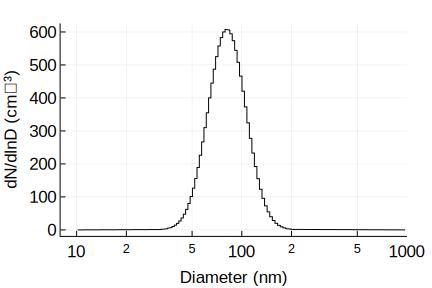

In [7]:
𝕟 = DMALognormalDistribution([[400, 80, 1.3]], δ)
p = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre, right_margin = 25px,
    legend = :none, ylabel = "dN/dlnD (cm⁻³)", xlim = (8,1000),  color =  :black, 
    xlabel = "Diameter (nm)",fmt = :svg)

<b> Figure 2. </b> Single mode lognormal size distribution for $N_{t,1} = 400\; cm^{-3}$, $D_{pg,1} = 80\; nm$, and $\sigma_{g,1} = 1.3$. Unlike Figure 1, the diameter range and bin number is determined by the DMA binning.

### (b) Triangular size distribution 
The triangular size distribution is generated via a call to the function "𝕥 = triangular(Λ, δ, A)", where Λ, δ define the DMA. The array consists of two elements, A = [Nt, Dm], where Nt is the total number concentration and D, is the mode diameter. Here the triangular distribution is defined as the DMA tranfer function that is scaled such that $\int_0^\infty \frac{dN}{d\ln D_p} d\ln D_p = Nt$ 

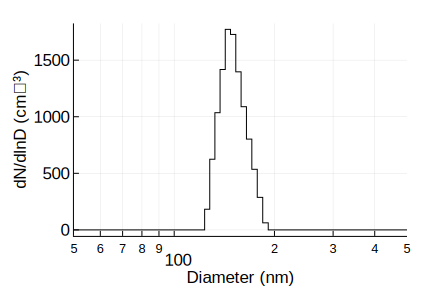

In [8]:
𝕥 = triangular(Λ, δ, [400, 150])
p = plot(𝕥.Dp, 𝕥.S, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre, right_margin = 25px,
    legend = :none, ylabel = "dN/dlnD (cm⁻³)", xlim = (50,500), color =  :black, 
    xlabel = "Diameter (nm)", fmt = :svg)

<b> Figure 3. </b> Triangular size distribution for $N_{t} = 400\; cm^{-3}$, $D_{m} = 100\; nm$. The diameter range and bin number is determined by the DMA binning. The width of the distribution is determined by the DMA transfer function, which in turn is controlled by $\beta$.

## Block 3. Size distribution arithmetic


The file aerosolsizedistribution.jl defines seven mathematical operations that act on size distribution objects. These are <br>
__(a) Multiplication of scalar and size distribution<br>
(b) Multiplication of vector and size distribution<br>
(c) Multiplication of matrix and size distribution<br>
(d) Multiplication of size distribution and size distribution<br>
(e) Division of size distribution and size distribution<br>
(f) Dot product of scalar and size distribution<br>
(g) Dot product of vector and size distribution<br>
(h) Addition of two size distributions__<br>
Combined these operations will be used to manipulate size distributions throughout this work. Some examples  are they transit through the DMA (multiplication of matrix and size distribution), transit through hygroscopic growth conditioner (dot product of scalar and size distribution), or assembly of partial size distributions that are limited to a single charge state (addition of two size distributions). In the this section definitions and examples for each operation are provided.

### (a) Multiplication of scalar and size distribution
Let a denote a floating point scalar and $𝕟$ denote a size distribution. Then
```julia
𝕩 = a*𝕟 
```
is defined such that
```julia
𝕩.N = a*𝕟.N
𝕩.S = a*𝕟.S
```
The net result is a scaling of the number concentration of the spectra by a.

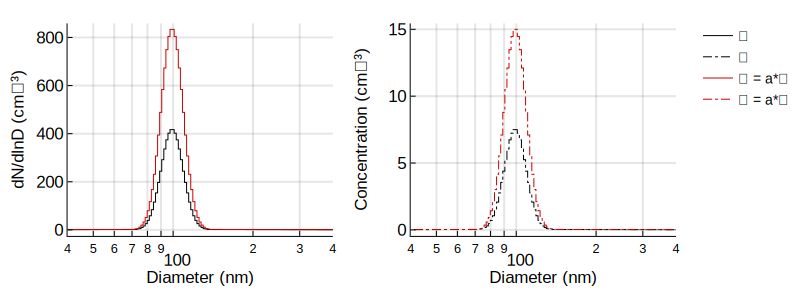

In [9]:
a = 2.0 # Note that a must be a floating point number
𝕟 = lognormal([[100, 100, 1.1]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
𝕩 = a*𝕟 # Example multiplication

figure("Nimbus Sans L", 2, 5.5, 2, 8)
p1 = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, lt = :steppre,
    label = "𝕟", ylabel = "dN/dlnD (cm⁻³)", xlim = (40,400), color =  :black,
    xlabel = "Diameter (nm)", right_margin = 25px)
p1 = plot!(𝕩.Dp, 𝕩.S, xaxis = :log10, label = "𝕩 = a*𝕟",  
    color = RGBA(0.8,0,0,1), lt = :steppre)

p2 = plot(𝕟.Dp, 𝕟.N, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre,
    label = "𝕟", ylabel = "Concentration (cm⁻³)", xlim = (40,400), color =  :black,
    xlabel = "Diameter (nm)", right_margin = 25px, ls = :dashdot)
p2 = plot!(𝕩.Dp, 𝕩.N, xaxis = :log10, label = "𝕩 = a*𝕟", ls = :dashdot,
    color = RGBA(0.8,0,0,1), lt = :steppre)

plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg)

<b> Figure 4. </b> Illustration of of the operator a$*$𝕟 for a = 2. The operation doubles both number concentration and spectral density fields.

### (b) Multiplication of  vector and size distribution
Let T denote a 1D vector that has the same number of elements as the size distribution $𝕟$. Then
```julia
𝕩 = T * 𝕟 
```
is defined such that 
```julia
𝕩.N = T * 𝕟.N
𝕩.S = T * 𝕟.S
```
The operator $*$ denotes elementwise multiplication (or broadcasting in Julia terminology). The net result is a bin-by-bin scaling of the number concentration. 

<b> Note that in the original version 𝕩 = T .* 𝕟 was used to indicate broadcasting. Due to changes between Julia versions and the underlying implementation of broadcasting, the .* was changed to * </b>

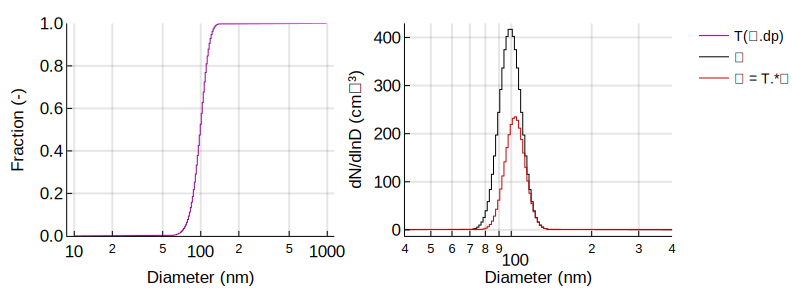

In [10]:
𝕟 = lognormal([[100, 100, 1.1]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
μ,σ = 100.0, 200.0
T = 0.5*(1.0 .+ erf.((𝕟.Dp .- μ)./(sqrt(2σ)))) # Simple error function with mean μ and std. dev σ
𝕩 = T*𝕟                                        # Example multiplication

figure("Nimbus Sans L", 2, 5.5, 2, 8)
p1 = plot(𝕟.Dp, T, xaxis = :log10, label = "T(𝕟.dp)", ylabel = "Fraction (-)", ylim = (0,1),
    color = RGBA(0.6,0,0.6,1), lt = :steppre, xlabel = "Diameter (nm)")
p2 = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, lt = :steppre, right_margin = 25px, color =  :black,
    label = "𝕟", ylabel = "dN/dlnD (cm⁻³)", xlim = (40,400), xlabel = "Diameter (nm)")
p2 = plot!(𝕩.Dp, 𝕩.S, xaxis = :log10, label = "𝕩 = T.*𝕟", color = RGBA(0.8,0,0,1), lt = :steppre)
plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg)

<b> Figure 5. </b> Illustration of the operator T$*$𝕟. The array T is defined for each diameter point of the distribution. The convolution 𝕩 = T$*$𝕟 also applies to number concentration (not shown).

### (c) Multiplication of  matrix and size distribution
Let <b>A</b> denote a $n\times n$ matrix where $n$ equals the number of size bins of $𝕟$. Then
```julia
𝕩 = 𝐀*𝕟 
```
is defined such that 
```julia
𝕩.N = 𝐀*𝕟.N
𝕩.S = 𝐀*𝕟.S
```
The operator $*$ denotes matrix multiplication. 

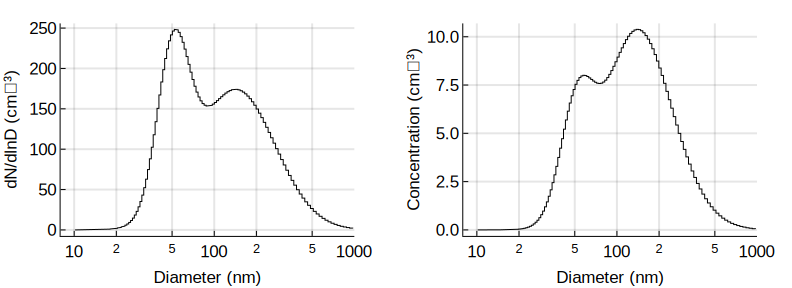

In [11]:
𝕟 = DMALognormalDistribution([[130, 50, 1.3], [280, 140, 1.9]],δ);
𝕩 = δ.𝐀*𝕟 

p1 = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, xticks = [10, 100, 1000], legend = :none, 
    ylabel = "dN/dlnD (cm⁻³)", xlim = (8,1000), color =  :black, xlabel = "Diameter (nm)", 
    right_margin = 35px, lt = :steppre)

p2 = plot(𝕩.Dp, 𝕩.N, legend = :none,  xaxis = :log10, right_margin = 35px, lt = :steppre,
    ylabel = "Concentration (cm⁻³)", xlim = (8,1000), color =  :black, xlabel = "Diameter (nm)")

plot(p1,p2,grid=(1,2), fmt = :svg)

<b> Figure 6. </b> Illustration of the operator <b>A</b>$*$𝕟. The matrix <b>A</b> is the convolution matrix defined in Notebook S02. The convolution 𝕩 = <b>A</b>$*$𝕟 also applies to S (not shown).

### (d) Multiplication of size distribution and size distribution
Let 𝕟₁ and 𝕟₂ denote a two size distribution defined on the same diameter grid. Then
```julia
𝕩 = 𝕟₁*𝕟₂ 
```
is defined such that 
```julia
Nsq = 𝕟₁.N*𝕟₂.N
𝕩.N = sum(𝕟₁.N)*sum(𝕟₂.N)*Nsq./sum(Nsq)
𝕩.S = N./𝕟₁.ΔdlnD
```
The net result is a size distribution that has total number concentration $N_t^2$. For a probability distributions that by definition integrate to unity, this operation corresponds to the product of two random variates with distribution 1 and 2.

<b> Note that in the original version 𝕩 = 𝕟₁.* 𝕟₂ was used to indicate broadcasting. Due to changes between Julia versions and the underlying implementation of broadcasting, the .* was changed to * </b>

Nt1 = 120, Nt2 = 90, Nt1*Nt2 = 10800, sum(𝕩.N) = 10800

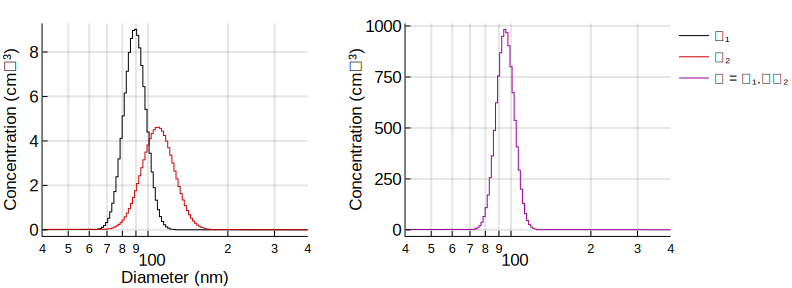

In [12]:
𝕟₁ = lognormal([[120, 90, 1.10]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
𝕟₂ = lognormal([[90, 110, 1.15]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
𝕩 = 𝕟₁*𝕟₂ 

p1 = plot(𝕟₁.Dp, 𝕟₁.N, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre,
    label = "𝕟₁", ylabel = "Concentration (cm⁻³)", xlim = (40,400), color =  :black,
    xlabel = "Diameter (nm)", right_margin = 25px)
p1 = plot!(𝕟₂.Dp, 𝕟₂.N, xaxis = :log10, label = "𝕟₂",color = RGBA(0.8,0,0,1), lt = :steppre)

p2 = plot(𝕩.Dp, 𝕩.N, xaxis = :log10, label = "𝕩 = 𝕟₁.∗𝕟₂", color = RGBA(0.6,0,0.6,1), 
    lt = :steppre, ylabel = "Concentration (cm⁻³)", xlim = (40,400))

@printf("Nt1 = %i, Nt2 = %i, Nt1*Nt2 = %i, sum(𝕩.N) = %i", 
        sum(𝕟₁.N), sum(𝕟₂.N), sum(𝕟₁.N)*sum(𝕟₂.N), sum(𝕩.N))
plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg)

<b> Figure 7. </b>   Illustration of the operator 𝕟₁∗𝕟₂. Note that the number concentration of the distribution is squared, and not that of individual bins.

### (e) Division of size distribution and size distribution

Let 𝕟₁ and 𝕟₂ denote a two size distribution defined on the same diameter grid. Then

```julia
𝕩 = 𝕟₁ / 𝕟₂
```
is defined such that
```julia
N = 𝕟₁.N ./ 𝕟₂.N
S = 𝕟₁.S ./ 𝕟₂.S
```

The net result is a size distribution that is the ratio of the concentration vectors

<b> Note that in the original version 𝕩 = 𝕟₁ ./ 𝕟₂ was used to indicate broadcasting. Due to changes between Julia versions and the underlying implementation of broadcasting, the ./ was changed to / </b>

Nt1 = 120, Nt2 = 61, Nt1*Nt2 = 7281, sum(𝕩.N) = 134

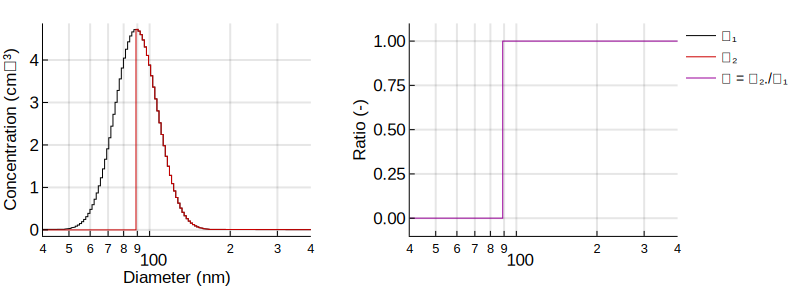

In [13]:
𝕟₁ = lognormal([[120, 90, 1.20]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
𝕟₂ = deepcopy(𝕟₁)
𝕟₂.N[𝕟₂.Dp .<= 90] .= 0
𝕟₂.S[𝕟₂.Dp .<= 90] .= 0
𝕩 = 𝕟₂/𝕟₁

p1 = plot(𝕟₁.Dp, 𝕟₁.N, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre, xlabel = "Diameter (nm)",
    label = "𝕟₁", ylabel = "Concentration (cm⁻³)", xlim = (40,400), color =  :black, right_margin = 25px)
p1 = plot!(𝕟₂.Dp, 𝕟₂.N, xaxis = :log10, label = "𝕟₂",color = RGBA(0.8,0,0,1), lt = :steppre)#

p2 = plot(𝕩.Dp, 𝕩.N, xaxis = :log10, label = "𝕩 = 𝕟₂./𝕟₁", color = RGBA(0.6,0,0.6,1), 
    lt = :steppre, ylabel = "Ratio (-)", xlim = (40,400), ylim = (-0.1,1.1))

@printf("Nt1 = %i, Nt2 = %i, Nt1*Nt2 = %i, sum(𝕩.N) = %i", 
        sum(𝕟₁.N), sum(𝕟₂.N), sum(𝕟₁.N)*sum(𝕟₂.N), sum(𝕩.N))
plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg)

<b> Figure 8. </b> Illustration of the operator 𝕟₂/𝕟₁. Note that the ratio is computed elementwise. 

### (f) Dot product of scalar and size distribution
Let a denote a floating point scalar and $𝕟$ denote a size distribution. Then
```julia
𝕩 = a⋅𝕟
```
is defined such that 
```julia
𝕩.Dp = a*𝕟.Dp 
```
The net result is a uniform diameter shift of the size distribution.

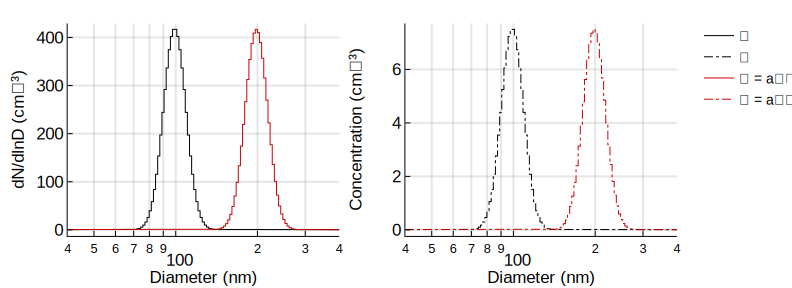

In [14]:
a = 2.0 # Note that a must be a floating point number
𝕟 = lognormal([[100, 100, 1.1]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
𝕩 = a⋅𝕟 

p1 = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, lt = :steppre, label = "𝕟", ylabel = "dN/dlnD (cm⁻³)", 
    xlim = (40,400), color =  :black, xlabel = "Diameter (nm)", right_margin = 25px)
p1 = plot!(𝕩.Dp, 𝕩.S, xaxis = :log10, label = "𝕩 = a⋅𝕟",  color = RGBA(0.8,0,0,1), lt = :steppre)

p2 = plot(𝕟.Dp, 𝕟.N, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre, label = "𝕟", 
    ylabel = "Concentration (cm⁻³)", xlim = (40,400), color =  :black, xlabel = "Diameter (nm)", 
    right_margin = 25px, ls = :dashdot)
p2 = plot!(𝕩.Dp, 𝕩.N, xaxis = :log10, label = "𝕩 = a⋅𝕟", ls = :dashdot, color = RGBA(0.8,0,0,1), lt = :steppre)

plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg) 

<b> Figure 9. </b> Illustration of the operator a⋅𝕟. The operation intuitively shifts the size distribution by a factor of two. Note, however, that the underlying diameter grid remains unchanged. This is achieved by interpolating the shifted size distribution back onto the original diameter grid. For this reason, the final fields dp and de are unaltered.  

### (g) Dot product of vector and size distribution
Let T denote a floating point vector with the same number of elements as the size distribution 𝕟. Then
```julia
𝕩 = T.⋅𝕟 
```
is defined such that 
```julia
𝕩.Dp = T.*𝕟.dp 
```
The net result is diameter dependent shift of the size distribution.

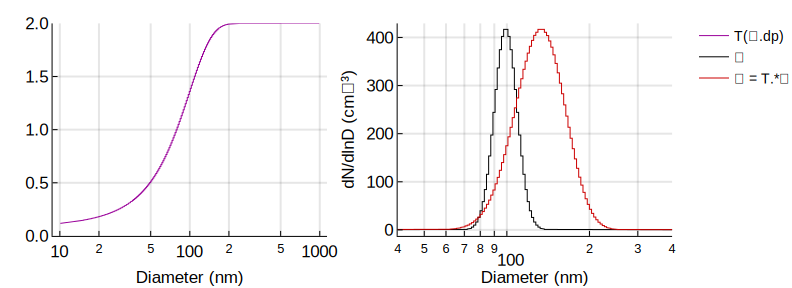

In [15]:
𝕟 = lognormal([[100, 100, 1.1]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
μ,σ = 80.0, 2000.0

T = (1.0 .+ erf.((𝕟.Dp .- μ)./(sqrt(2σ)))) # Simple error function with mean μ and std. dev σ
𝕩 = T⋅𝕟                             

figure("Nimbus Sans L", 2, 5.5, 2, 8)
p1 = plot(𝕟.Dp, T, xaxis = :log10, label = "T(𝕟.dp)", xlabel = "Diameter (nm)",color = RGBA(0.6,0,0.6,1), 
    lt = :steppre, ylim = (0,2))

p2 = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, lt = :steppre, xlabel = "Diameter (nm)", 
    label = "𝕟", ylabel = "dN/dlnD (cm⁻³)", xlim = (40,400), color =  :black, right_margin = 25px)
p2 = plot!(𝕩.Dp, 𝕩.S, xaxis = :log10, label = "𝕩 = T.*𝕟", color = RGBA(0.8,0,0,1), lt = :steppre)

plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg)

<b> Figure 10. </b> Illustration of the operator T.⋅𝕟. The operation distorts the size distribution. For value T > 1, the size distribution shifts to larger values, for T < 1 the size distribution shifts to smaller values. Note, however, that the underlying diameter grid remains unchanged. This is achieved by interpolating the shifted size distribution back onto the original diameter grid.  

### (h) Addition of two size distributions
Let 𝕟₁ and 𝕟₂ denote a two size distribution defined on the same diameter grid. Then
```julia
𝕩 = 𝕟₁+𝕟₂ 
```
is defined such that 
```julia
𝕩.S = 𝕟₁.S + 𝕟₂.S 
𝕩.N = 𝕩.S.*𝕟₁.ΔlnD 
```
The net result is the superposition of size distributions.

Nt1 = 120, Nt2 = 90, sum(𝕩.N) = 210

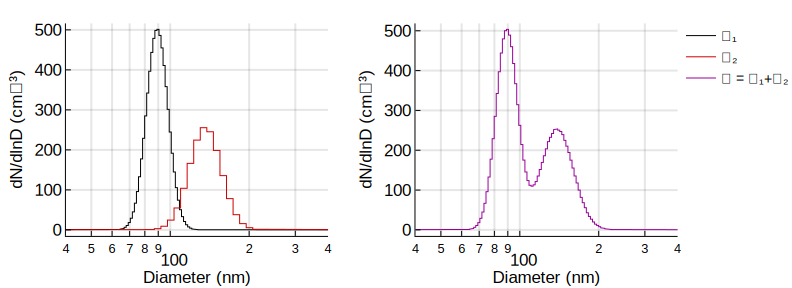

In [16]:
𝕟₁ = lognormal([[120, 90, 1.10]]; d1 = 10.0, d2 = 1000.0, bins = 256);  # size distribution
𝕟₂ = lognormal([[90, 140, 1.15]]; d1 = 20.0, d2 = 800.0, bins = 64);    # size distribution
𝕩 = 𝕟₁+𝕟₂   # Example addition, note the mismatch of the grid 

p1 = plot(𝕟₁.Dp, 𝕟₁.S, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre,
    label = "𝕟₁", ylabel = "dN/dlnD (cm⁻³)", xlim = (40,400), color =  :black,
    xlabel = "Diameter (nm)", right_margin = 25px)
p1 = plot!(𝕟₂.Dp, 𝕟₂.S, xaxis = :log10, label = "𝕟₂", lt = :steppre, color = RGBA(0.8,0,0,1))

p2 = plot(𝕩.Dp, 𝕩.S, xaxis = :log10, label = "𝕩 = 𝕟₁+𝕟₂", xlabel = "Diameter (nm)",
    color = RGBA(0.6,0,0.6,1), lt = :steppre, ylabel = "dN/dlnD (cm⁻³)", xlim = (40,400))

@printf("Nt1 = %i, Nt2 = %i, sum(𝕩.N) = %i", sum(𝕟₁.N), sum(𝕟₂.N), sum(𝕩.N))
plot(p1,p2, grid = (1,2),left_margin = 20px, fmt = :svg)

<b> Figure 11. </b> Illustration of the operator 𝕟₁+𝕟₂. The operation intuitively superimposed the two distributions into a single distribution. As shown in the example, the two 𝕟₁+𝕟₂ distributions do not share the same grid. In case of a grid mismatch, the new size distribution will use the grid for 𝕟₁.

## Block 4. Under the hood

Size distribution arithmetic is implemented via multiple dispatch. Multiple dispatch means that a function is dynamically dispatched based on the runtime types of its arguments. Operators are functions that are implemented in julia. For example the expression 

```julia 
a * b```

is shorthand for 
```julia
*(a, b)```
where 
```julia
*()``` 
is a function. At runtime variables a and b can have different types, e.g. a::Float64 and b::Float64 or a::Int and b::Int or a::String b::String. Depending on the type at runtime, different versions of the function $*$(a,b) are invoked. For examples, multiplication of strings is string concatenation, while multiplication of two integers produces another integer. 

In [17]:
println("Hello"*" World")
println(*("Hello", " World"))
println(*(3,4))

Hello World
Hello World
12


DifferentialMobilityAnalyzer.jl defines a datatype called SizeDistribution. To implement 𝕟₁+𝕟₂ in case of +(𝕟₁::SizeDistribution, 𝕟₂:SizeDistribution) the following simple routine defined in aerosolsizedistribution.jl is dispatched. <br>

```julia
function +(𝕟₁::SizeDistribution, 𝕟₂::SizeDistribution)
	if 𝕟₁.Dp ≠ 𝕟₂.Dp
		N = clean((interpolate((𝕟₂.Dp,),𝕟₂.N,Gridded(Linear())))[𝕟₁.Dp])
		S = clean((interpolate((𝕟₂.Dp,),𝕟₂.S,Gridded(Linear())))[𝕟₁.Dp])
		S = 𝕟₁.S + S
	else
		S = 𝕟₁.S + 𝕟₂.S
	end
	N = S.*𝕟₁.ΔlnD

    return SizeDistribution([[]],𝕟₁.De,𝕟₁.Dp,𝕟₁.ΔlnD,S,N,:distsum)
end

```

The other operations shown above are implemented in a similar straightforward manner.

## References

Seinfeld, J.H. and Pandis, S.N. (2006) Atmospheric Chemistry and Physics: From Air Pollution to Climate Change. 2nd Edition, John Wiley & Sons, New York. 